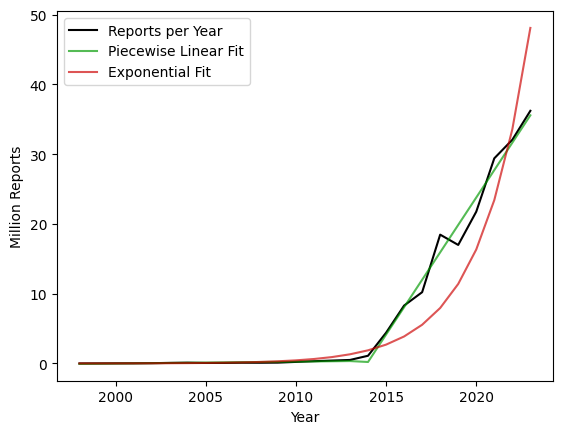

In [1]:
import sys
sys.path.insert(0, '..')

import math
import matplotlib
import numpy as np
import pandas as pd
from intransparent import delete_latex_tables, show

show('<h1>Overview of CyberTipline Reports</h1>')
show(
    """
    Per <a href="https://www.law.cornell.edu/uscode/text/18/2258A">18 US Code
    §2258A</a>, a number of activities related to the sexual exploitation of
    children must be reported to the National Center for Missing and Exploited
    Children or NCMEC. The following overview of the reports is based on NCMEC's
    <a
    href="https://www.missingkids.org/content/dam/missingkids/pdfs/OJJDP-NCMEC-Transparency_2022-Calendar-Year.pdf">2022
    Report to the Office of Juvenile Justice and Delinquency Prevention</a>.
    """
)

show('<h2>Number of Reports</h2>')
show(
    """
    NCMEC started its CyberTipline in 1998. Since then, the number of reports
    has increased significantly, doubling in many but not nearly all years.
    NCMEC has characterized this growth as exponential in the above transparency
    report. Alas, I am not convinced that is the case. As the figure below
    shows, a piecewise linear fit over 1998–2013 and 2014–2022 seems more
    accurate.
    """
)
reports_per_year = pd.read_csv(
    '../data/csam-reports-per-year.csv',
    thousands=',',
    index_col='year'
)

part = reports_per_year.loc[reports_per_year.index < 2014]['reports']
fit = np.polyfit(part.index, part, 1)
reports_per_year.loc[reports_per_year.index < 2014, 'fit'] = np.poly1d(fit)(part.index)

part = reports_per_year.loc[reports_per_year.index >= 2014]['reports']
fit = np.polyfit(part.index, part, 1)
reports_per_year.loc[reports_per_year.index >= 2014, 'fit'] = np.poly1d(fit)(part.index)

log_reports = np.log(reports_per_year['reports'])
fit = np.polyfit(log_reports.index, log_reports, 1)
reports_per_year['exp_fit'] = [math.exp(fit[1] + fit[0] * x) for x in log_reports.index]

reports_per_year = reports_per_year.rename(columns={
    'reports': 'Reports per Year',
    'fit': 'Piecewise Linear Fit',
    'exp_fit': 'Exponential Fit',
})

ax = reports_per_year.plot.line(color=['#000000', '#009900aa', '#cc0000aa'])
ax.set_xlabel('Year')
ax.set_ylabel('Million Reports')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/1_000_000), ',')))

ax.get_figure().savefig('../figure/reports-per-year.svg', format='svg')

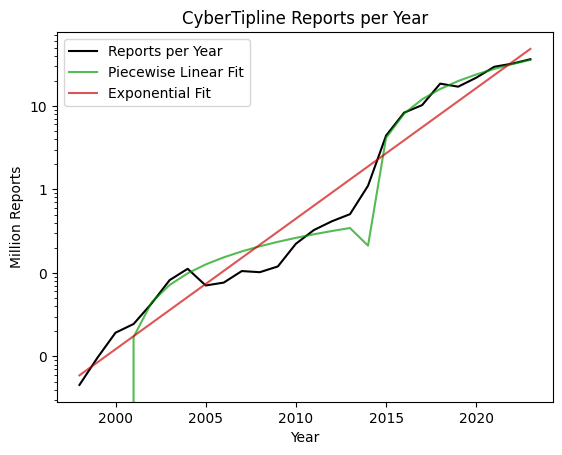

In [2]:
ax = reports_per_year.plot.line(color=['#000000', '#009900aa', '#cc0000aa'])

ax.set_title('CyberTipline Reports per Year')
ax.set_xlabel('Year')
ax.set_ylabel('Million Reports')
ax.set_yscale('log')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/1_000_000), ',')))


In [3]:
contents = pd.read_csv('../data/csam-report-contents.csv', thousands=',')

totals = (
    contents[(contents['category'] == 'reports') & (contents['label'] == 'total')]
    .drop(columns=['category', 'label'])
    .set_index('year')['quantity']
)

prep = (
    contents[contents['category'] == 'kind of exploitation']
    .drop(columns='category')
    .pivot(index='label', columns='year', values='quantity')
)
assert totals.equals(prep.sum())

violations = pd.DataFrame(index=prep.index)
for year, entries in prep.items():
    violations[year] = entries
    violations[f'{year} %'] = entries / totals[year] * 100

show('<h2>Reported Activities</h2>')
show(
    """
    A number of activities related to the sexual exploitation of children must
    be reported. But in practice almost all reports concern child pornography,
    i.e., <em>child sexual abuse material</em> (CSAM).
    """
)

def percentage_columns(df: pd.DataFrame) -> list[str]:
    return [c for c in df.columns if isinstance(c, str) and '%' in c]

show(
    violations.sort_values(by=2023, ascending=False),
    caption='Reported Activities (in Descending Order for 2023)',
    highlight_columns=percentage_columns(violations),
    highlight_rows='child pornography',
)


,2020,2020 %,2021,2021 %,2022,2022 %,2023,2023 %
label,,,,,,,,
child pornography,"21,669,264",99.62383,"29,309,106",99.69870,"31,901,234",99.50780,"35,925,098",99.21219
online enticement of children,"37,872",0.17412,"44,155",0.15020,"80,524",0.25117,"186,819",0.51593
obscene material sent to a child,"3,547",0.01631,"5,177",0.01761,"35,624",0.11112,"45,746",0.12633
child sexual molestation,"11,770",0.05411,"12,458",0.04238,"12,906",0.04026,"18,021",0.04977
child sex trafficking,"15,879",0.07300,"16,032",0.05453,"18,336",0.05719,"17,353",0.04792
misleading words/images online,"8,689",0.03995,"5,825",0.01981,"7,517",0.02345,"8,446",0.02332
misleading domain name,"3,109",0.01429,"3,304",0.01124,"1,948",0.00608,"6,883",0.01901
child sex tourism,955,0.00439,"1,624",0.00552,940,0.00293,"2,002",0.00553


In [4]:
pieces = (
    contents[contents['category'] == 'attachments']
    .drop(columns='category')
    .pivot(index='year', columns='label', values='quantity')
)

pieces['reports'] = totals
pieces['pieces'] = pieces['photos'] + pieces['videos']
pieces['unique pieces'] = pieces['unique photos'] + pieces['unique videos']
pieces['similar pieces'] = pieces['similar photos'] + pieces['similar videos']
pieces['π(⏵)'] = pieces['pieces'] / totals
pieces['π(⏴)'] = pieces['pieces'] / pieces['unique pieces']
pieces['π(⏴⏴)'] = pieces['pieces'] / pieces['similar pieces']
pieces = pieces[
    [
        'reports',
        'π(⏵)',
        'pieces',
        'π(⏴)',
        'unique pieces',
        'π(⏴⏴)',
        'similar pieces',
    ]
]

show('<h2>Report Attachments</h2>')
show(
    """
    <p>Each report may have one or more attachments or <em>pieces</em>.
    Commonly, a piece is a photo or video. NCMEC uses MD5 to determine unique
    pieces and PhotoDNA as well as Videntity to determine perceptually similar
    pieces.</p>

    <p>Given that <a
    href="https://marc-stevens.nl/research/papers/StLdW%20-%20Chosen-Prefix%20Collisions%20for%20MD5%20and%20Applications.pdf">chosen
    prefix attacks against MD5</a> have been practical for years now, it is
    deeply concerning that NCMEC claimed the opposite in 2023, stating that <a
    href="https://www.missingkids.org/content/dam/missingkids/pdfs/OJJDP-NCMEC-Transparency_2022-Calendar-Year.pdf">[i]mages
    that share the same MD5 hash are identical</a>. The organization would be
    well-advised to cease making such false claims and switch to a stronger
    cryptographic hash, such as SHA-3.</p>

    <p>In the table below, columns labeled with "π(...)" (for product) contain
    the multiplicative factors relating reports, unique pieces, and similar
    pieces with the number of pieces in the highlighted column. Clearly, the
    same CSAM pieces are reported over and over again.</p>
    """
)

show(
    pieces,
    caption='Reports vs Pieces',
    highlight_columns='pieces',
)


label,reports,π(⏵),pieces,π(⏴),unique pieces,π(⏴⏴),similar pieces
year,,,,,,,
2020,"21,751,085",3.00,"65,344,724",2.39,"27,333,171",4.62,"14,141,118"
2021,"29,397,681",2.88,"84,795,507",2.32,"36,625,281",3.85,"22,005,389"
2022,"32,059,029",2.72,"87,179,813",2.01,"43,399,901",3.21,"27,136,862"
2023,"36,210,368",2.88,"104,370,572",2.09,"49,979,320",3.10,"33,640,168"


In [5]:
overreports = (
    contents[contents['category'] == 'reports']
    .drop(columns='category')
    .pivot(index='year', columns='label', values='quantity')
)
overreports['π(⏴)'] = (
    overreports['total'] / overreports['with unique photos/videos']
)
overreports['π(⏴⏴)'] = (
    overreports['total'] / overreports['with similar photos/videos']
)
overreports = overreports[
    [
        'total',
        'π(⏴)',
        'with unique photos/videos',
        'π(⏴⏴)',
        'with similar photos/videos',
    ]
]

show(
    """
    Since pieces are reported over and over again, reports should be redundant
    as well, albeit to a lesser degree. That is the case indeed.
    """
)

show(
    overreports,
    caption='Total, Unique, and Similar Reports',
    highlight_columns='total',
)

label,total,π(⏴),with unique photos/videos,π(⏴⏴),with similar photos/videos
year,,,,,
2020,"21,751,085",1.52,"14,269,712",2.46,"8,854,071"
2021,"29,397,681",1.35,"21,814,959",1.77,"16,589,193"
2022,"32,059,029",1.37,"23,404,207",1.66,"19,307,139"
2023,"36,210,368",1.33,"27,281,685",1.62,"22,330,009"


In [6]:
rel = (
    pd.read_csv('../data/csam-pieces-by-relationship-to-victim.csv', thousands=',')
    .set_index("relationship")
    .rename(columns=lambda c: tuple(c.split(maxsplit=1)))
    .pipe(lambda df: df.drop(columns=[c for c in df.columns if c[1] == "pieces"]))
    .rename(columns=lambda c: c[0])
)

piece_totals = rel.sum()
relationships = pd.DataFrame(index=[*rel.index.values, 'Total'])

for year, entries in rel.items():
    # Include total counts
    entries.loc['Total'] = piece_totals[year]
    relationships[year] = entries
    relationships[f'{year} %'] = entries / piece_totals[year] * 100

social_distance = {
    'nuclear family': [
        'Brother', 'Father', 'Mother', 'Sister'],
    'romantic partner': ['Boyfriend', 'Girlfriend'],
    'extended family': [
        'Aunt', 'Brother-in-Law', 'Cousin', 'Foster Sibling', 'Grandfather',
        'Grandmother', "Guardian's Partner", 'Half Sibling', 'Legal Guardian',
        'Other Relative', 'Step-Father', 'Step-Grandparent', 'Step-Mother', 'Uncle'
    ],
    'supervisory': ['Babysitter, Mentor, Coach, Teacher'],
    'socially familiar': ['Neighbor/Family friend', 'Photographer'],
    'stranger': [
        'Online Enticement/Self & Offender Produced', 'Trafficking', 'Stranger'
    ],
}

for label, values in social_distance.items():
    relationships.loc[values, 'social_distance'] = label

show('<h2>Relationship to Victim</h2>')
show(
    """
    Based on separate reports by law enforcement, NCMEC determined the
    relationship between abuser and child for each unique photo and video. The
    table below shows the data as released by NCMEC.
    """
)
show(
    relationships.drop(columns='social_distance').sort_values('2023', ascending=False),
    caption='Relationship to Victim per Unique Piece (in Descending Order for 2023)',
    highlight_columns=percentage_columns(relationships),
)

relationship_summary = (
    relationships
    .groupby('social_distance')
    .sum()
    .sort_values('2023 %', ascending=False)
)

show(
    """
    We can classify these rather fine-grained relationships in the above table
    by approximate <em>social distance</em> into the following groups, ordered
    from closest to farthest:
    """
    """
    <ol>
    <li>Nuclear family</li>
    <li>Romantic Partner</li>
    <li>Extended family</li>
    <li>Supervisory role</li>
    <li>Socially familiar</li>
    <li>Stranger</li>
    </ol>
    """
    """
    The table below shows the corresponding counts. Apparently, drag queens
    aren't the threat some people make them out to be.
    """
)
show(
    relationship_summary,
    caption='Summary of Relationship Data',
    highlight_columns=percentage_columns(relationship_summary),
    highlight_rows='family',
)


,2020,2020 %,2021,2021 %,2022,2022 %,2023,2023 %
Total,"996,361",100.00000,"1,384,499",100.00000,"1,238,363",100.000000,"1,347,739",100.000000
Father,"299,486",30.05798,"399,480",28.85376,"376,633",30.413780,"362,244",26.877904
Neighbor/Family friend,"140,555",14.10683,"209,373",15.12265,"172,858",13.958589,"212,720",15.783471
Guardian's Partner,"71,700",7.19619,"116,525",8.41640,"77,413",6.251237,"164,637",12.215793
Mother,"35,090",3.52182,"50,956",3.68046,"49,396",3.988814,"134,688",9.993626
Uncle,"85,313",8.56246,"119,621",8.64002,"99,164",8.007668,"85,222",6.323331
Photographer,"75,572",7.58480,"77,247",5.57942,"53,904",4.352843,"80,093",5.942768
Step-Father,"59,419",5.96360,"80,080",5.78404,"100,676",8.129765,"74,224",5.507298
Online Enticement/Self & Offender Produced,"68,626",6.88766,"90,386",6.52843,"115,319",9.312213,"70,104",5.201601
"Babysitter, Mentor, Coach, Teacher","74,510",7.47821,"127,942",9.24103,"69,638",5.623392,"58,674",4.353514


,2020,2020 %,2021,2021 %,2022,2022 %,2023,2023 %
social_distance,,,,,,,,
nuclear family,"343,891",34.515,"464,071",33.519,"439,771",35.512,"507,786",37.677
extended family,"269,467",27.045,"381,604",27.563,"355,603",28.716,"385,189",28.580
socially familiar,"216,127",21.692,"286,620",20.702,"226,762",18.311,"292,813",21.726
stranger,"90,320",9.065,"115,439",8.338,"138,458",11.181,"96,502",7.160
supervisory,"74,510",7.478,"127,942",9.241,"69,638",5.623,"58,674",4.354
romantic partner,"2,046",0.205,"8,823",0.637,"8,131",0.657,"6,775",0.503
